# Model project: A Solow-Swan model with semi-endogenous growth 

Imports and set magics:

In [395]:
import numpy as np
from scipy import optimize
import sympy as sm
from IPython.display import display
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve
%matplotlib inline

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

The following model is the Solow-Swan model extended to include semi-endogenous growth of technology. In steady-state the level of GDP per worker is highly dependent on the growth of technology, and therefore it is interesting to examine the case of endogenous growth. 

*The four equations of the model are:* 

$Y_t = K_t^\alpha (A_t L_t)^{1-\alpha}$
 
$A_t=K_t^\phi , \phi<1$

$K_{t+1}=sY_t+(1-\delta)K_t$

$L_{t+1}=(1+n)L_t$


$Y_t$ is output, $K_t$ is capital, $A_t$ is technology and $L_t$ is the labor force. These are the variables of the model. The parameters are $\alpha, \phi, s, \delta, n$, where $\alpha$ is the output elasticity of capital and labor, $\phi$ is the return from capital to the technological level, $\delta$ is the depreciation of capital, n is the growth of labor. s is the savings which is equal to investments, since it is a closed economy. 

## Analytical solution

To solve the model we have to find the steady state value for k and y. We need to define the model in terms of effective labor units. By doing so and substituting technology and labor into the production function and capital accumulation function our model consists of two equations. Lower case letters implies a variable in terms of effective labor units.

In [396]:
# Variables and parameters defined to be shown in equations

alpha = sm.symbols("alpha")
phi = sm.symbols("phi")
delta = sm.symbols("delta")
s = sm.symbols("s")
n = sm.symbols("n")
ke = sm.symbols("\hat{k}_t")
ke1 = sm.symbols("\hat{k}_{t+1}")
ye = sm.symbols("\hat{y}_t")
kss = sm.symbols("k^*")
yss = sm.symbols("y^*")
k = sm.symbols("K_t")
l = sm.symbols("L_t")
k1 = sm.symbols("K_{t+1}")
l1 = sm.symbols("L_{t+1}")
a = sm.symbols("A_t")
a1 = sm.symbols("A_{t+1}")
y = sm.symbols("Y_t")

# We define the model equations but the equation for technology as growth rate
Tech_g = sm.Eq(a1, (k1/k)**phi*a)
Labor = sm.Eq(l1, (1+n)*l)
capitalaccumulation = sm.Eq(k1, (1-delta)*k+s*y)
Production = sm.Eq(ye, ke**alpha)
# We find the transition equation
equation1 = sm.Eq(ke1/ke, (k1/(a1*l1))/(k/(a*l)))
equation2 = equation1.subs({a1: Tech_g.rhs,l1: Labor.rhs})
equation3 = equation2.subs({k1: capitalaccumulation.rhs})
equation4= sm.Eq(equation3.lhs, equation3.rhs*((a*l)/(a*l)))
# We redefine equation4 in terms of effective labor units
equation5 = sm.Eq(equation4.lhs, (1/(1+n))*(s*ye/ke+(1-delta))**(1-phi))
equation6 = equation5.subs({ye: Production.rhs})
Transitionequation = sm.Eq(equation6.lhs*ke, equation6.rhs*ke)
display(Transitionequation)


Eq(\hat{k}_{t+1}, \hat{k}_t*(-delta + 1 + \hat{k}_t**alpha*s/\hat{k}_t)**(1 - phi)/(n + 1))

We use SymPy to calculate the steady state values for y and k by substituting the steady state value for k and y into their respectively variables with time subscripts. We can then solve for the steady state value of k by using the solve function. To find the steady state value of y we substitute the steady state value of k into the production function.

In [397]:
# We substitute the steady state values of y and k into the equations
sst = sm.Eq(ke, kss)
sst1 = sm.Eq(ke1, kss)
ysst = sm.Eq(ye, yss)

Transition_ss = Transitionequation.subs({ke: sst.rhs, ke1: sst1.rhs})
Production_ss = Production.subs({ye: ysst.rhs, ke: sst.rhs})

# We solve for k steady state
k_ss_solve = sm.solve(Transition_ss, kss)
y_ss = Production_ss.subs(kss, k_ss_solve[0])
k_ss = sm.Eq(kss, k_ss_solve[0])

display(k_ss)
display(y_ss)

Eq(k^*, ((delta - 1 + (n + 1)**(-1/(phi - 1)))/s)**(1/(alpha - 1)))

Eq(y^*, (((delta - 1 + (n + 1)**(-1/(phi - 1)))/s)**(1/(alpha - 1)))**alpha)

We want to find a value for k and y in the steady state and to do that we define the steady state equations as functions and thereafter we use parametervalues to find a value.

In [398]:
# We define the steady state values as fundtions
k_ss_func = sm.lambdify(args=(s,alpha,delta,phi,n),expr=k_ss_solve[0])
y_ss_func = sm.lambdify(args=(s,alpha,delta,phi,n),expr=y_ss.rhs)

# The parameter values are defined as follows
s_val = 0.101
alpha_val = 0.33
delta_val = 0.05
phi_val = 0.5
n_val = 0.02

solk = k_ss_func(s_val,alpha_val,delta_val,phi_val,n_val)
soly = y_ss_func(s_val,alpha_val,delta_val,phi_val,n_val)

print(f"The steady state value of capital is {solk:.2f}")
print(f"The steady state value of output is {soly:.2f}")

The steady state value of capital is 1.18
The steady state value of output is 1.06


## Numerical solution

We start by defining the transition equation and set all k's equal. We set the equation equal to zero by moving the left hand side k to the right side. We use the Brentq method to find the roots of the function and search in the interval [0.01,100] for a steady state k. We insert the steady state k into the production function to find the steady state y. 

In [399]:
# We define the transition equation as a function
def f(k):
    return k - k/(1+n_val) * (s_val * k**(alpha_val - 1) + 1 - delta_val)**(1 - phi_val)

# We find the root of the function
k = brentq(f, 0.01, 100)

y = k**alpha_val

print(f"The steady state value of capital is {k:.2f}")
print(f"The steady state value of output is {y:.2f}")

The steady state value of capital is 1.18
The steady state value of output is 1.06


We note that both methods achieves the same results. 

# Further analysis

In the next section we wish to examine the sensitivity of the steady state values of k and y with changes in the return of learning by doing. We create a vector of values of $\phi$ from 0 up to 1. We loop our results and create a simple line plot. 

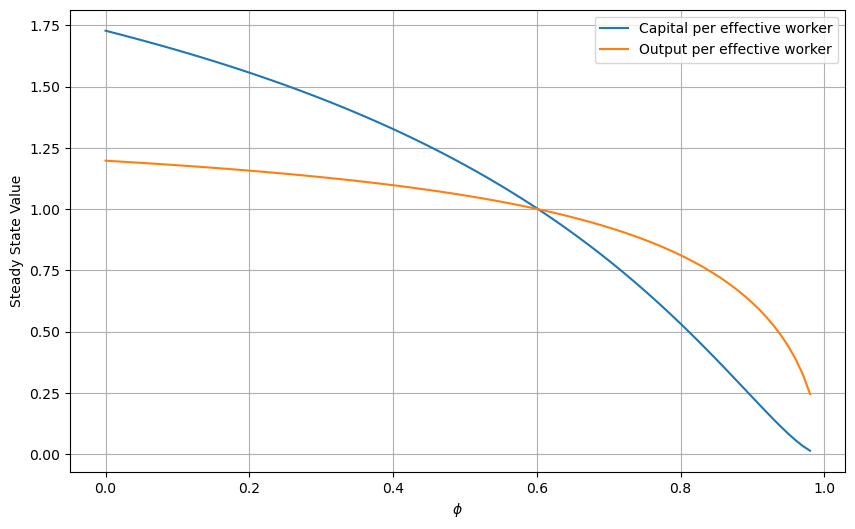

In [400]:
phi_vec = np.arange(0, 0.99, 0.01)

def f(k_phi, phi_val):
    return k_phi - k_phi/(1+n_val) * (s_val * k_phi**(alpha_val - 1) + 1 - delta_val)**(1 - phi_val)

# We create empy lists
k_values = []
y_values = []

# We loop over different values of phi_val
for phi_val in phi_vec:
    k_phi = brentq(f, 0.01, 100, args=(phi_val,))
    y_phi = k_phi**alpha_val
    # We append the values to the lists
    k_values.append(k_phi)
    y_values.append(y_phi)

# We create a line plot
plt.figure(figsize=(10, 6))
plt.plot(phi_vec, k_values, label='Capital per effective worker')
plt.plot(phi_vec, y_values, label='Output per effective worker')
plt.xlabel('$\phi$')
plt.ylabel('Steady State Value')
plt.legend()
plt.grid(True)
plt.show()

The steady state values of k and y are declining for an increasing value of $\phi$. Since the steady state variables are per effective worker, a lower value means a higher value of capital and output. 

The steady state technological growth rate is given as:
$g=(1+n)^{\phi/(1-\phi)}-1$,
which is equal to the growth rate of capital and output in steady state. 

In the next section we examine the sensitivity of g as the growth in labor force and return of learning by doing changes. We start by examining g for changes in n and $\phi$ seperately by keeping the other value at their baseline value. 

In [401]:
# We create vectors with values for n and phi
phi_vec_res1 = np.arange(0, 1, 0.1)
n_vec1 = np.arange(0, 0.05, 0.005)

# We solve the value of g
g_n=(1+n_vec1)**(phi_val/(1-phi_val))-1 #g_n is the growth rate of varying n's
g_phi=(1+n_val)**(phi_vec_res1/(1-phi_vec_res1))-1 #g_phi is the growth rate of varying phi's

print("g_n:")
for n, value in zip(n_vec1, g_n):
    print(f"n: {n:.3f}, g_n: {value:.2f}")

print("g_phi")
for phi, value in zip(phi_vec_res1, g_phi):
    print(f"phi: {phi:.1f}, g_phi: {value:.2f}")

g_n:
n: 0.000, g_n: 0.00
n: 0.005, g_n: 0.28
n: 0.010, g_n: 0.63
n: 0.015, g_n: 1.07
n: 0.020, g_n: 1.64
n: 0.025, g_n: 2.35
n: 0.030, g_n: 3.26
n: 0.035, g_n: 4.40
n: 0.040, g_n: 5.83
n: 0.045, g_n: 7.64
g_phi
phi: 0.0, g_phi: 0.00
phi: 0.1, g_phi: 0.00
phi: 0.2, g_phi: 0.00
phi: 0.3, g_phi: 0.01
phi: 0.4, g_phi: 0.01
phi: 0.5, g_phi: 0.02
phi: 0.6, g_phi: 0.03
phi: 0.7, g_phi: 0.05
phi: 0.8, g_phi: 0.08
phi: 0.9, g_phi: 0.20


From the output we see that both a higher n and $\phi$ leads to a higher growth rate. Furthermore we observe that the growth rate explodes for high values of labor force growth. 

We wish to analyze the combined effects of n and $\phi$ on the growth rate. To do this we create a 3D plot. 

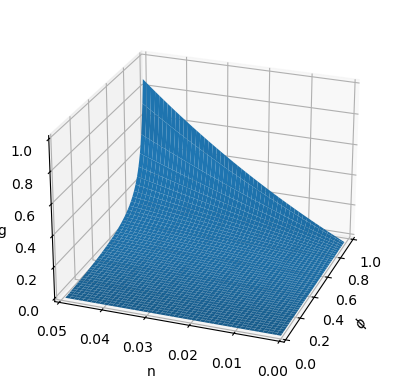

In [402]:
phi_vec_res = np.arange(0, 0.94, 0.01) # We restrict phi to maximum 0.94 to avoid explosive growth rates. 
n_vec = np.arange(0, 0.050, 0.001)

# We create a meshgrid for phi and n
phi_mesh, n_mesh = np.meshgrid(phi_vec_res, n_vec)

# We solve g for each pair of phi and n
g_mesh = (1 + n_mesh)**(phi_mesh / (1 - phi_mesh)) - 1

# We reate a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(phi_mesh, n_mesh, g_mesh)

ax.set_ylim(0, 0.05)
ax.set_xlim(0, 1)
ax.set_zlim(0, 1)

ax.view_init(elev=25, azim=200)

ax.set_xlabel('$\phi$')
ax.set_ylabel('n')
ax.set_zlabel('g')
ax.zaxis.labelpad=0.05

plt.show()

From the figure we see that both larger values of $\phi$ and n results in a higher technological growth rate. 

# Model extension

We can improve the model by including human capital. Human capital is the skills the individual worker has, such as education, experience and IQ. The extended model looks as the following:

$Y_t = K_t^\alpha H_t^\gamma (A_t L_t)^{1-\alpha-\gamma}$
 
$A_t=K_t^\phi , \phi<1$

$K_{t+1}=s_kY_t+(1-\delta)K_t$

$H_{t+1}=s_hY_t+(1-\delta)H_t$

$L_{t+1}=(1+n)L_t$

H is the new variable for human capital and the new equation is the equation for human capital accumulation. We now assume that the technological growth through learning by doing comes from both physical capital and human capital.

To solve the model we find the transition equations for $\tilde k$ and $\tilde h$ and use the assumption that in the steady state both $\tilde k$ and $\tilde h$ are constant. 

The transition equations are:

$\tilde{k}_{t+1}=\frac{1}{1+n}(s_k\tilde{k}_t^{\frac{\alpha-1}{1-\phi}}\tilde{h}_t^{\gamma}+(1-\delta)k_t^{\frac{1}{1-\phi}})^{1-\phi}$

$\tilde{h}_{t+1}=\frac{1}{1+n}(s_h\tilde{k}_t^{\alpha}\tilde{h}_t^{\gamma}+(1-\delta)h_t)(s_k\tilde{k}_t^{\alpha-1}\tilde{h}_t^{\gamma}+(1-\delta))^{-\phi}$




We solve it numerically with fsolve to take into account that there are multiple equations in steady state which brentq can not handle. We choose new parameter values and change the existing values of $\phi$ and n to avoid explosive growth. 

In [403]:
# We define the values for the parameters
sh_val = 0.2
sk_val = 0.15
n_val_new = 0.025 
alfa_val = 0.30
gamma_val = 0.35
phi_val_new = 0.3

# We create a function for the two steady state equations
def f(var):
    k, h = var
    k_trans = ((sk_val*k**(alfa_val-1)*h**gamma_val+(1-delta_val))**(1-phi_val_new)/(1+n_val_new)-1)
    h_trans = ((sh_val*h**(gamma_val-1)*k**alfa_val+(1-delta_val))*(sk_val*k**(alfa_val-1)*h**gamma_val+(1-delta_val))**(-phi_val_new)/(1+n_val_new)-1)
    return [k_trans, h_trans]

# List of initial guesses
initial_guesses = [(0, 0), (1, 1), (10, 10), (100, 100)]

# Loop over initial guesses
for initial_guess in initial_guesses:
    with np.errstate(all='ignore'):
     # Solve for steady state
     k,h = fsolve(f, initial_guess)
     k_trans, h_trans = f((k, h))
        
    print("With initial guess {}, the steady state value for k and h is {:.2f} and {:.2f}, and the corresponding values for k_trans and h_trans are {:.4f} and {:.4f}".format(initial_guess, k, h, k_trans, h_trans))


With initial guess (0, 0), the steady state value for k and h is 0.00 and 0.00, and the corresponding values for k_trans and h_trans are nan and nan
With initial guess (1, 1), the steady state value for k and h is 6.56 and 8.74, and the corresponding values for k_trans and h_trans are 0.0000 and -0.0000
With initial guess (10, 10), the steady state value for k and h is 6.56 and 8.74, and the corresponding values for k_trans and h_trans are 0.0000 and 0.0000
With initial guess (100, 100), the steady state value for k and h is 100.00 and 100.00, and the corresponding values for k_trans and h_trans are -0.0381 and -0.0283


We find that the steady state values changes for different guesses which could indicate that there are multiple equlibriums or non.

We can calculate the scalareffects of the two transitionequations. According to the Solow-Swan-model with humancapital the scalareffects needs to be larger than 1. 

In [404]:
Scalar_k = (alfa_val-1+gamma_val)*(1-phi_val_new)
Scalar_h = (gamma_val-1+alfa_val)+(alfa_val-1+gamma_val)*(-phi_val_new)

print(f"The scalar of transition_k is {Scalar_k:.2f}")
print(f"The scalar of transition_h is {Scalar_h:.2f}")

The scalar of transition_k is -0.24
The scalar of transition_h is -0.25


The scalareffect is negative for both transitionsequations which indicates that our model is not consistent with the humancapital model. Next we will test to see if there are some parameter values which makes it possible to achieve scalareffects larger than 1. To do this we make a loop that tests if the value of the scalarproduct for k and h are larger than 1. The code tests all values for alpha, gamma and phi between 0 and 1. Alpha+gamma<1 such that the productionfunction has a constant scalarproduct.

In [405]:
# Define the range of values to test
values = np.linspace(0, 1, 100)

# Loop over all combinations of values for alfa_val, gamma_val, and phi_val_new
for alfa_val in values:
    for gamma_val in values:
        if alfa_val + gamma_val < 1:
            for phi_val_new in values:
                # Calculate scalar_k and scalar_h
                scalar_k = (alfa_val-1+gamma_val)*(1-phi_val_new)
                scalar_h = (gamma_val-1+alfa_val)+(alfa_val-1+gamma_val)*(-phi_val_new)
                
                # Check if both scalar_k and scalar_h are greater than 0
                if scalar_k > 1 and scalar_h > 1:
                    print(f"For alfa_val={alfa_val}, gamma_val={gamma_val}, phi_val_new={phi_val_new}, both scalar_k and scalar_h are greater than 0 and 1 - alfa_val - gamma_val = 0.")
else:
    print("It is not possible")

It is not possible


We find that it is not possible to achieve a scalarproduct larger than 1 for both equations at the same time. Therefore our model extension is not a valid model extension.

# Conclusion

Through our analysis we are able to conclude that a higher return of learning by doing from capital results in lower values of steady state $\tilde{k}$ and $\tilde{y}$. In turn this means that a higher $\phi$ means higher values of K and Y in steady state. We find that both higher values of $\phi$ and n results in a higher growth rate in steady state.

Our extended model is similar to our original model, but the addition of human capital makes it possible to differentiate between different kinds of capital. 